In [60]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception  
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [35]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3

In [36]:
data_dir = '/kaggle/input/trashnet/dataset-resized'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 2527 files belonging to 6 classes.


In [37]:
class_names = dataset.class_names

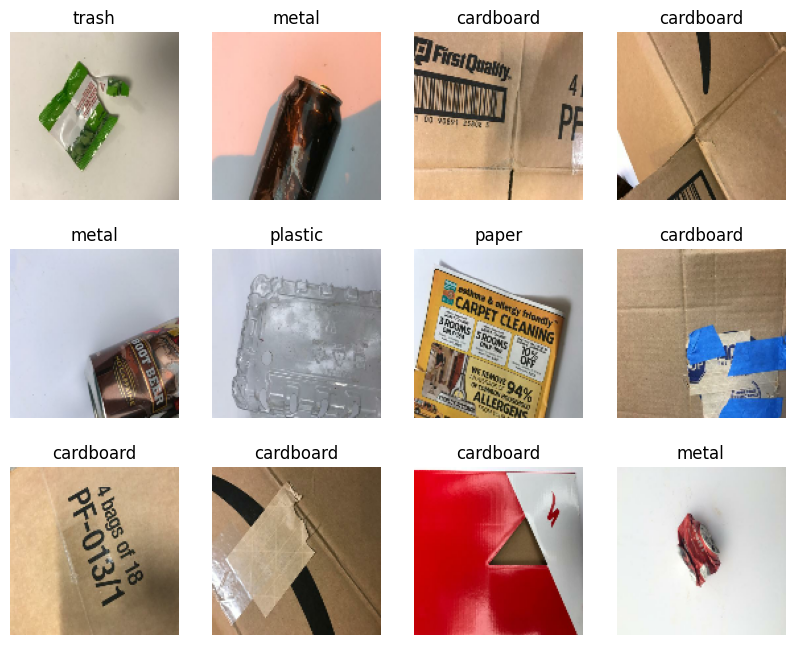

In [38]:
plt.figure(figsize=(10,8))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
    plt.show()

In [39]:
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)

    train_ds = ds.take(train_size)

    test_ds = ds.skip(train_size)

    return train_ds, test_ds

In [40]:
train_ds, test_ds = get_dataset_partitions_tf(dataset)

In [41]:
print(f"Training : {len(train_ds)}\nTesting : {len(test_ds)}")

Training : 63
Testing : 16


In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
resize_data_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [44]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [45]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [46]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Define your image size and channels
base_model = Xception(weights='imagenet', 
                             input_shape=input_shape, 
                             include_top=False)

model = models.Sequential([
    resize_data_rescale,  # Assuming resize_data_rescale is defined elsewhere
    base_model,  # DenseNet121 as feature extractor
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [47]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
history = model.fit(train_ds, 
                    epochs=10, 
                    validation_data=test_ds, 
                    batch_size=BATCH_SIZE
                   )

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 348ms/step - accuracy: 0.4917 - loss: 1.3841 - val_accuracy: 0.4853 - val_loss: 3.6908
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.8016 - loss: 0.6104 - val_accuracy: 0.7847 - val_loss: 1.1884
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.8984 - loss: 0.3484 - val_accuracy: 0.7867 - val_loss: 0.9505
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.9385 - loss: 0.2201 - val_accuracy: 0.8160 - val_loss: 0.6672
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.9219 - loss: 0.2303 - val_accuracy: 0.8630 - val_loss: 0.5444
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.9552 - loss: 0.1548 - val_accuracy: 0.8063 - val_loss: 0.8905
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.9614 - loss: 0.1266 - val_accuracy: 0.8415 - val_loss: 0.7567
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.9758 - loss: 0.0947 - val_accu

In [49]:
scores = model.evaluate(test_ds)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9308 - loss: 0.2257


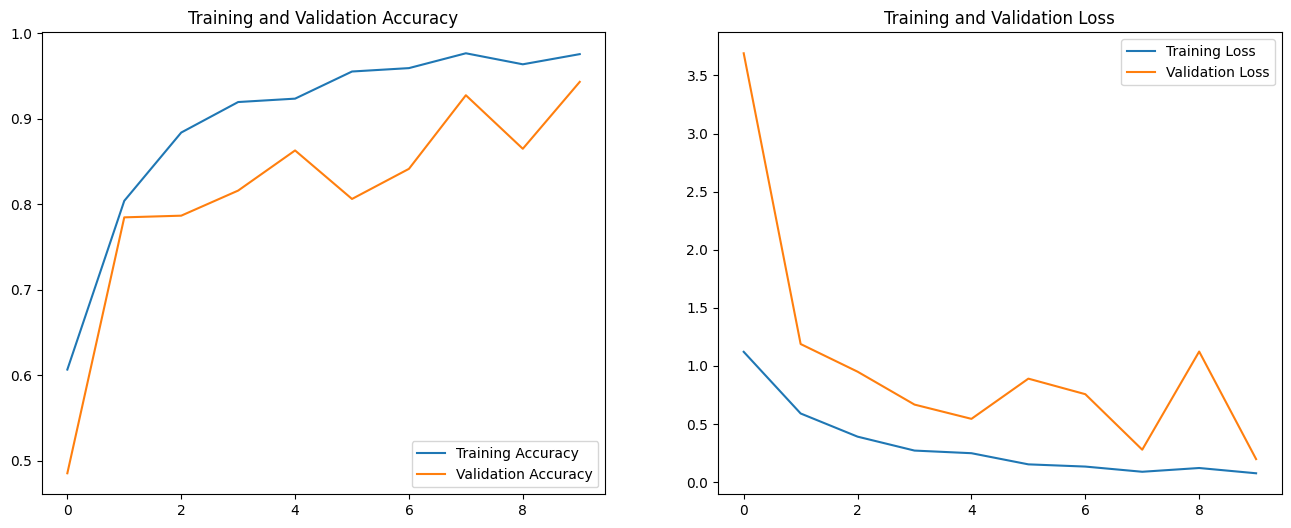

In [50]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


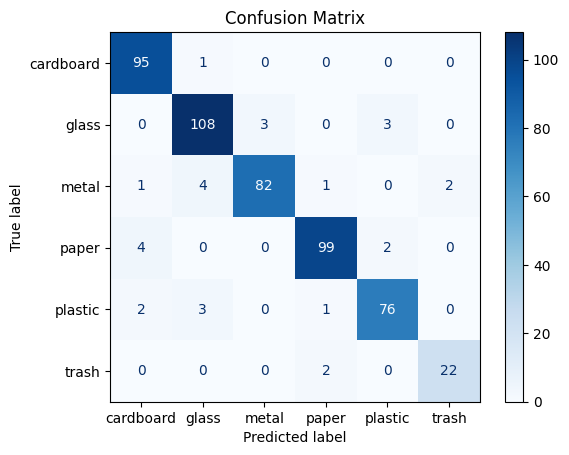

In [63]:
y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_pred.extend(tf.argmax(predictions, axis=1).numpy()) 
    y_true.extend(labels.numpy())  

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [64]:


print(classification_report(y_true, y_pred, target_names=class_names))



              precision    recall  f1-score   support

   cardboard       0.93      0.99      0.96        96
       glass       0.93      0.95      0.94       114
       metal       0.96      0.91      0.94        90
       paper       0.96      0.94      0.95       105
     plastic       0.94      0.93      0.93        82
       trash       0.92      0.92      0.92        24

    accuracy                           0.94       511
   macro avg       0.94      0.94      0.94       511
weighted avg       0.94      0.94      0.94       511



In [65]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


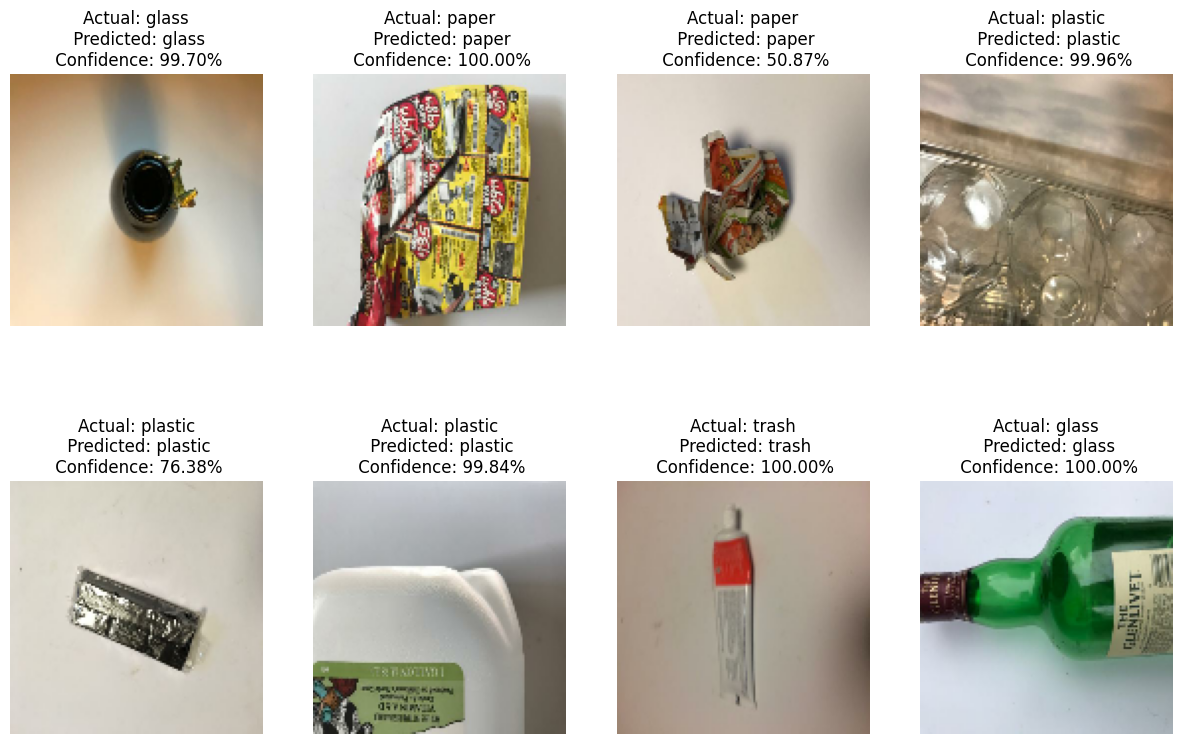

In [68]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(2):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence:.2f}%")
        
        plt.axis("off")

In [69]:
model.save("/kaggle/working/model_version_1.h5")